In [1]:
# based on 10.1021/acs.jctc.5b00875
# bucket highQ-benzene-f510a6b3317f3c717957e8717baeefa4

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sco

In [3]:
datafile = '/mnt/c/Users/guido/data/highQ-benzene-f510a6b3317f3c717957e8717baeefa4/ccsd-t/extract'

In [24]:
def read_file(datafile):
    with open(datafile) as fh:
        lines = fh.readlines()
    res = []
    for line in lines:
        row = {}
        if "Reference" in line:
            row['component'] = "HF"
        else:
            row['component'] = "CE"
        row['mol'] = line[:4]
        row['order'] = {'D': 2, 'T': 3, 'Q': 4, '5': 5}[line[5]]
        row['energy'] = float(line.strip().split()[-1])
        res.append(row)
    return pd.DataFrame(res)
df = read_file(datafile).sort_values(by="order").query("order > 1")

-1.109566497261756


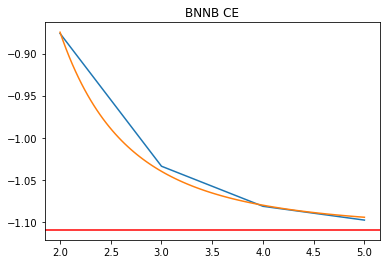

-237.57127920459146


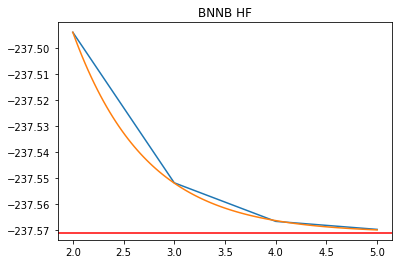

-1.1133713659531201


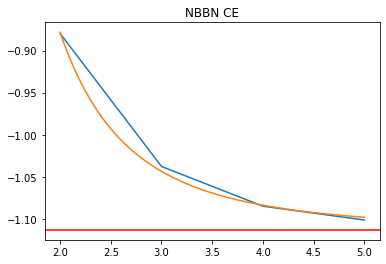

-237.55965724912832


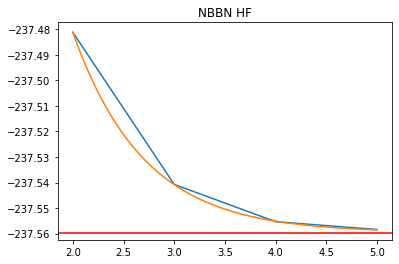

In [31]:
def fit_ce(group):
    def modelfunc(xs, alpha, ecbs):
        return ecbs+(alpha/xs**3)
    xs = group.order.values
    ys = group.energy.values
    popt, pcov = sco.curve_fit(modelfunc, xs, ys)
    
    xss = np.linspace(min(xs), max(xs), 100)
    yss = modelfunc(xss, *popt)
    return xss, yss, popt[-1]
def fit_hf(group):
    def modelfunc(xs, alpha, beta, ecbs):
        return ecbs+alpha*np.exp(-beta**2*xs)
    xs = group.order.values
    ys = group.energy.values
    popt, pcov = sco.curve_fit(modelfunc, xs, ys, p0=(-1, 1, -230))
    
    xss = np.linspace(min(xs), max(xs), 100)
    yss = modelfunc(xss, *popt)
    return xss, yss, popt[-1]

for name, group in df.groupby("mol component".split()):
    plt.plot(group.order, group.energy)
    plt.title(' '.join(name))
    if name[-1] == 'CE':
        xss, yss, ecbs = fit_ce(group)
    else:
        xss, yss, ecbs = fit_hf(group)
    plt.plot(xss, yss)
    print (ecbs)
    plt.axhline(ecbs, color='red')
    plt.show()

In [36]:
def difference(order_min, order_max):
    mols = ['BNNB', 'NBBN']
    values = []
    for mol in mols:
        s = df.query("order >= @order_min & order <= @order_max & mol == @mol")
        sce = s.query("component == 'CE'")
        shf = s.query("component == 'HF'")
        values.append(fit_ce(sce)[-1] + fit_hf(shf)[-1])
    return (values[1] - values[0])

In [47]:
difference(2, 500)

0.007817086771780168